## Analysis of the Sample of the French Comedies

We will examine the 10% proportionate stratified random sample of the French 5-act verse comedies (29 comedies from different decades). 

We will explore the following questions:
1. The evolution of non-dialogues, monologues, and polylogues - does it make sense to combine monologues and polylogues into non-dialogues?
2. Determine potential boundaries between four periods using Euclidean distance;
3. Inspect potential boundaries between periods using visualizations.
4. Run descriptive statistics for the each period


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load the previously taken sample
sample_df = pd.read_csv('../French_Comedies/Data/French_Comedies_Data_Sample.csv')

In [3]:
sample_df.head()

,index,title,last_name,first_name,date,translation/adaptation/contrastive,num_acts,url,num_present_characters,num_scenes_text,...,percentage_above_two_speakers,av_percentage_non_speakers,sigma_iarkho,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters,total_utterances,num_verse_lines,dialogue_vivacity,five_year_intervals,decades
0,F_51,Les Apparences trompeuses,Boisrobert,François Le Métel de,1655,0,5,NaN,12,45,...,43.18,6.288,1.002,7,15.909,NaN,NaN,NaN,1655,1660
1,F_54,Le Marquis ridicule,Scarron,Paul,1656,0,5,http://www.theatre-classique.fr/pages/document...,10,24,...,43.24,22.387,1.692,3,8.108,637.0,1654.0,0.385,1660,1660
2,F_212,La Belle-mère ou les Dangers d'un second mariage,Vigée,Louis-Jean-Baptiste-Étienne,1788,0,5,NaN,10,42,...,16.67,4.167,0.950,5,11.905,NaN,NaN,NaN,1790,1790
3,F_206,L'École des pères,Pieyre,Alexandre,1787,0,5,NaN,9,63,...,13.64,10.606,0.785,2,3.030,NaN,NaN,NaN,1790,1790
4,F_266,Le Faux bonhomme,Duval,Alexandre,1821,0,5,NaN,8,42,...,26.67,6.481,1.134,0,0.000,NaN,NaN,NaN,1825,1830


In [4]:
# rename features to make them more understandalbe
sample_df = sample_df.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                      'percentage_non_duologues': 'percentage_non_dialogues',
                                      'percentage_above_two_speakers': 'percentage_polylogues'})

In [5]:
sample_df.shape

(29, 25)

In [6]:
# sort by date
sorted_sample = sample_df.sort_values(by='date')

# Part 1. The percentage of Non-dialogues, Monologues, and Polylogues

We can't be sure that the evolution of monologues and polylogues justifies combining them into one feature, i.e., he percentage of non-dialogues as Iarkho does. We will examine the behavior of these features using visualizations.

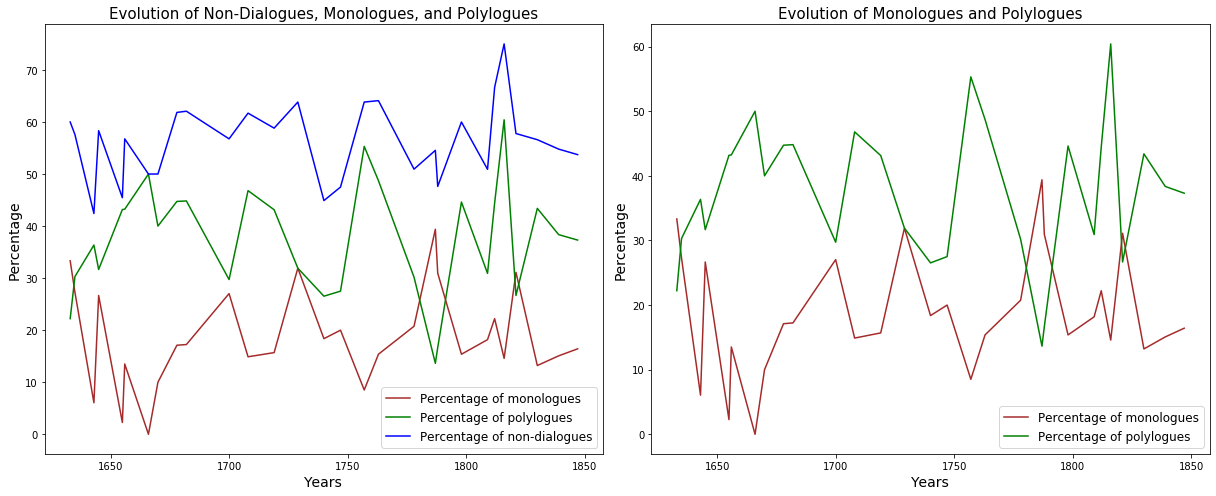

In [7]:
plt.figure(figsize=(17, 7))
plt.subplot(121)
plt.title('Evolution of Non-Dialogues, Monologues, and Polylogues', fontsize=15)
plt.plot(sorted_sample['date'], sorted_sample['percentage_monologues'], color='brown', label='Percentage of monologues')
plt.plot(sorted_sample['date'], sorted_sample['percentage_polylogues'], color='green', label='Percentage of polylogues')
plt.plot(sorted_sample['date'], sorted_sample['percentage_non_dialogues'], color='b', label='Percentage of non-dialogues')
plt.legend(loc='lower right', fontsize=12)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

plt.subplot(122)
plt.title('Evolution of Monologues and Polylogues', fontsize=15)
plt.plot(sorted_sample['date'], sorted_sample['percentage_monologues'], color='brown', label='Percentage of monologues')
plt.plot(sorted_sample['date'], sorted_sample['percentage_polylogues'], color='green', label='Percentage of polylogues')
plt.legend(loc='lower right', fontsize=12)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.tight_layout()
plt.show()

Based on this visualization, the percentage of monologues is the mirrow image of the percentage of polylogues. We can check this by inspecting the correlation between them.

In [8]:
sorted_sample[['percentage_polylogues', 'percentage_monologues']].corr()

,percentage_polylogues,percentage_monologues
percentage_polylogues,1.000000,-0.748575
percentage_monologues,-0.748575,1.000000


It turns out that the percentage of monologues and the percentage of polylogues have a rather strong negative correlations ≈ -0.75. By combining the two features into one, i.e., the percentage of non-dialogues, we obsure the picture: we get a feature which barely evolves over the decades. Based on this analysis, we will treat the percentage of monologues and the percentage of polylogues separately.

# Part 2. Euclidean Distance Between Time Periods

We will create a feature vector for each time period by adding up all the feature vectors corresponding to the plays belonging to this period and normalizing it. Next, we will calcuate the Euclidean distance between these time perid vectors. We will iterate over different boundaries and select such boundaries, that produce the maximum distance between the neighboring periods (i.e, period one and two, two and three, three and four). 

In [9]:
def determine_period(row, lower, middle, upper):
    """
    The function creates a column corresponding to time periods.
    Params:
        row - a row with the date
        lower - upper boundary of period one
        middle - upper boundary of period two
        upper - lower boundary of period three
    Returns:
        int - either 1, 2, 3, or 4 corresponding to the time period.
    """
    if row <= lower:
        period = 1
    elif row > lower and row <= middle:
        period = 2
    elif row > middle and row <= upper:
        period = 3
    else:
        period = 4
        
    return period

In [10]:
def calculate_distances(sample_df, features):
    distances = []
    for lower in range(1640, 1815, 5):
        for middle in range(1650, 1825, 5):
            for upper in range(1660, 1835, 5):
                if middle > lower and upper > middle and (middle - lower) >= 10 and (upper - middle) >= 10:
                    sample_df['period'] = sample_df['date'].apply(determine_period, args=[lower, 
                                                                                          middle, 
                                                                                          upper])

                    period_one = sample_df[sample_df.period == 1].copy()
                    period_two = sample_df[sample_df.period == 2].copy()
                    period_three = sample_df[sample_df.period == 3].copy()
                    period_four = sample_df[sample_df.period == 4].copy()
                    if len(period_one) > 2 and len(period_two) > 2 and len(period_three) > 2:
                        period_one_sum = normalize(period_one[features].sum().values.reshape(1, -1))

                        period_two_sum = normalize(period_two[features].sum().values.reshape(1, -1))
                        period_three_sum = normalize(period_three[features].sum().values.reshape(1, -1))
                        period_four_sum = normalize(period_four[features].sum().values.reshape(1, -1))
                        dist_one = euclidean_distances(period_one_sum.reshape(1, -1), 
                                                       period_two_sum.reshape(1, -1))
                        dist_two = euclidean_distances(period_two_sum.reshape(1, -1), 
                                                       period_three_sum.reshape(1, -1))
                        dist_three = euclidean_distances(period_three_sum.reshape(1, -1),
                                                         period_four_sum.reshape(1, -1))
                        mean_score = np.mean([dist_one, dist_two, dist_three])
                        distances.append((mean_score, lower, middle, upper))
    # return the potential boundaries with the maximum distance
    result = [dist for dist in distances if dist[0] == np.max([d[0] for d in distances])]                    
    
    return result

In [11]:
# rescale the feautures using StandardScaler to be able to calculate Euclidean distance
scaler = StandardScaler()
# define the features
features = ['num_present_characters', 
            'mobility_coefficient',
            'percentage_monologues',
            'percentage_polylogues',
            'sigma_iarkho']
sorted_sample_copy = sorted_sample.copy()
rescaled_features = scaler.fit_transform(sorted_sample_copy[features])

sorted_sample_copy[features] = rescaled_features

## Calculate the boundaries which produce the largest Euclidean distance

In [12]:
result = calculate_distances(sorted_sample_copy, features)

In [13]:
for res in result:
    print('Euclidean distance:', res[0], 'Period one:', res[1], 'Period two:', res[2],
          'Period three:', res[3], 'Period four:', res[3])

Euclidean distance: 1.8638468404538342 Period one: 1645 Period two: 1685 Period three: 1790 Period four: 1790
Euclidean distance: 1.8638468404538342 Period one: 1645 Period two: 1685 Period three: 1795 Period four: 1795
Euclidean distance: 1.8638468404538342 Period one: 1645 Period two: 1690 Period three: 1790 Period four: 1790
Euclidean distance: 1.8638468404538342 Period one: 1645 Period two: 1690 Period three: 1795 Period four: 1795
Euclidean distance: 1.8638468404538342 Period one: 1645 Period two: 1695 Period three: 1790 Period four: 1790
Euclidean distance: 1.8638468404538342 Period one: 1645 Period two: 1695 Period three: 1795 Period four: 1795
Euclidean distance: 1.8638468404538342 Period one: 1650 Period two: 1685 Period three: 1790 Period four: 1790
Euclidean distance: 1.8638468404538342 Period one: 1650 Period two: 1685 Period three: 1795 Period four: 1795
Euclidean distance: 1.8638468404538342 Period one: 1650 Period two: 1690 Period three: 1790 Period four: 1790
Euclidean 

There were a few possible solutions that produce the largest Euclidean distance of appr. 1.86. Therefore, it becomes necessary to investiage these potential boundaries using visualizations.

# Part 3. Visualizations of the Features and Time Periods

We will create joint scatterplots with kernel density plots for each feature and display potential period boundaries with dashed lines.

In [14]:
def scatter(df, feature, title, xlabel):
    sns.jointplot('date', 
               feature,
               data=df, 
               color='b', 
               height=7).plot_joint(
               sns.kdeplot, 
               zorder=0, 
               n_levels=7)
    # potential period boundaries
    plt.axvline(1645, color='grey',linestyle='dashed', linewidth=2)
    plt.axvline(1650, color='grey',linestyle='dashed', linewidth=2)
    plt.axvline(1685, color='grey',linestyle='dashed', linewidth=2)
    plt.axvline(1690, color='grey',linestyle='dashed', linewidth=2)
    plt.axvline(1695, color='grey',linestyle='dashed', linewidth=2)
    plt.axvline(1790, color='grey',linestyle='dashed', linewidth=2)
    plt.axvline(1795, color='grey',linestyle='dashed', linewidth=2)
    plt.title(title, fontsize=20, pad=100)
    plt.xlabel('Years', fontsize=14)
    plt.ylabel(xlabel, fontsize=14)

    plt.show()

## Number of Dramatic Characters

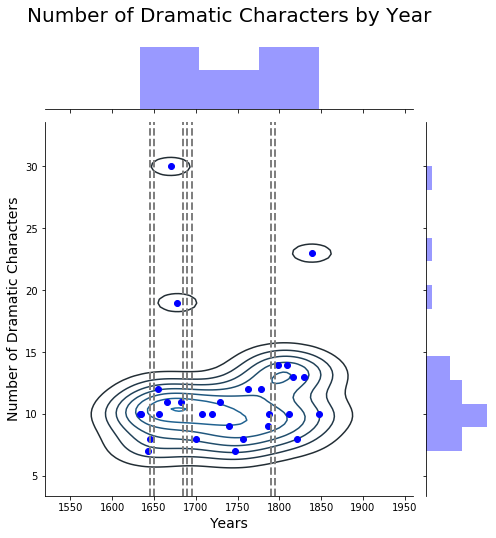

In [15]:
scatter(sample_df, 
        'num_present_characters', 
        'Number of Dramatic Characters by Year', 
        'Number of Dramatic Characters')

It looks like higher boundaries (i.e., 1650, 1695, 1795) reflect the natural separation in this feature more accurately.

## Mobility Coefficient

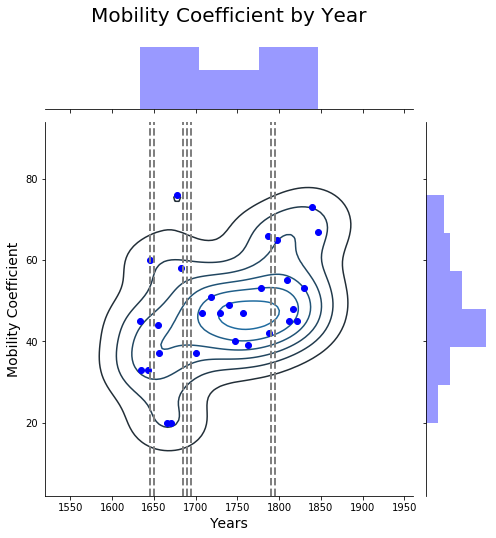

In [16]:
scatter(sample_df, 
        'mobility_coefficient', 
        'Mobility Coefficient by Year', 
        'Mobility Coefficient')

Based on this visualization, the same is true - higher boundaries are more reliable.

## Standard Range of the Speaking Characters (Sigma)

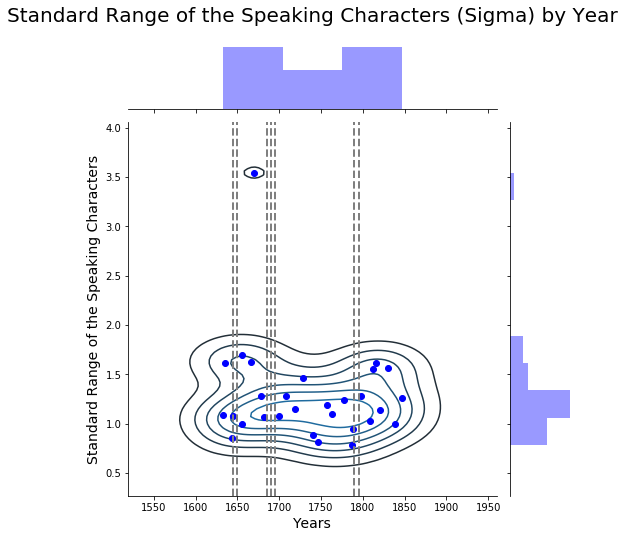

In [17]:
scatter(sample_df, 
        'sigma_iarkho', 
        'Standard Range of the Speaking Characters (Sigma) by Year', 
         'Standard Range of the Speaking Characters')

In case of sigma, once again it is safer to use a higher boundary, especally between periods one and two and three and four, to make sure the natural clustering in the data is preserved.

## Percentage of Non-Dialogues

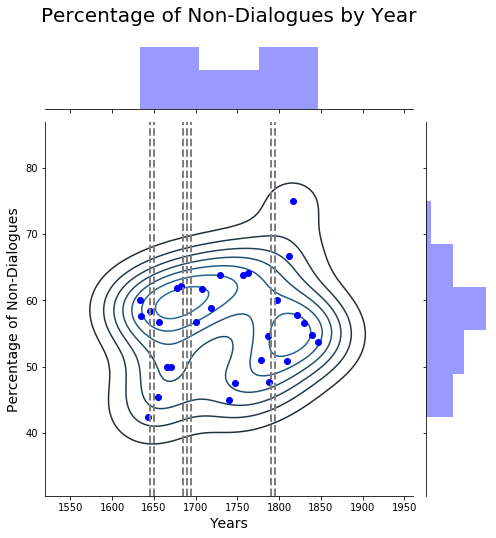

In [18]:
scatter(sample_df, 
        'percentage_non_dialogues', 
        'Percentage of Non-Dialogues by Year', 
        'Percentage of Non-Dialogues')

Even though we have determined that the percentage of non-dialogues is not a realible feature, the proposed higher boundaries do not contradict the natural clustering of this feature.

## Percentage of Polylogues

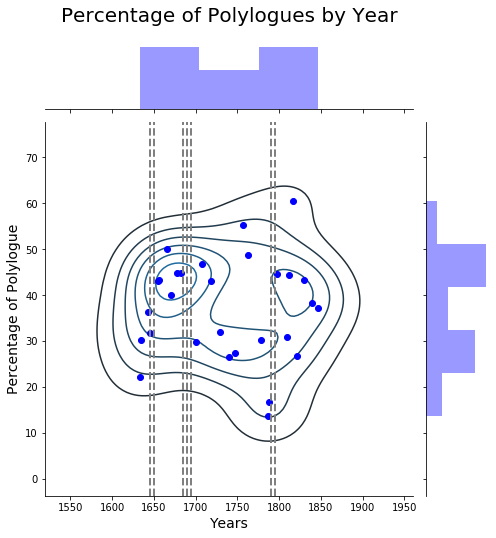

In [19]:
scatter(sample_df, 
        'percentage_polylogues', 
        'Percentage of Polylogues by Year', 
        'Percentage of Polylogue')

The higher boundaries find additional support in the visualization of the percentage of polylogues.

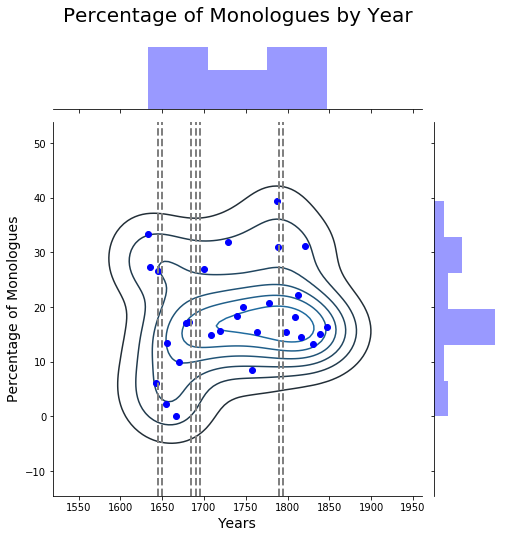

In [20]:
scatter(sample_df, 
        'percentage_monologues', 
        'Percentage of Monologues by Year', 
        'Percentage of Monologues')

The higher upper boundary also accurately separates the natural clustering of the plays according to the percentage of monologues.

Therefore, we hypothesize that the comedies fall into the following time periods:
1. From 1629 to 1650
2. From 1651 to 1695
3. From 1696 to 1795
4. From 1796 to 1847

In [21]:
sorted_sample['period'] = sorted_sample['date'].apply(determine_period, args=[1650, 
                                                                              1695, 
                                                                              1795])

# Part 4. Descriptive Statistics by Periods (Based on the Sample)

## Number of Dramatic Characters

In [22]:
sorted_sample.groupby('period').describe().loc[:, 'num_present_characters'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,8.750000,1.500000,9.0,7.0,10.0
2,15.500000,7.816649,11.5,10.0,30.0
3,9.636364,1.629278,10.0,7.0,12.0
4,13.125000,4.549333,13.0,8.0,23.0


## Mobility Coefficient

In [24]:
sorted_sample.groupby('period').describe().loc[:, 'mobility_coefficient'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,42.750000,12.816006,39.0,33.0,60.0
2,42.500000,21.943108,40.5,20.0,76.0
3,47.090909,8.092645,47.0,37.0,66.0
4,56.375000,10.729632,54.0,45.0,73.0


## Sigma

In [26]:
sorted_sample.groupby('period').describe().loc[:, 'sigma_iarkho'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,1.159500,0.321007,1.0845,0.856,1.613
2,1.702667,0.944500,1.4540,1.002,3.543
3,1.083545,0.208814,1.1000,0.785,1.460
4,1.304375,0.245199,1.2720,1.000,1.610


## Percentage of Non-Dialogues

In [27]:
sorted_sample.groupby('period').describe().loc[:, 'percentage_non_dialogues'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,54.582500,8.171179,57.955,42.42,60.00
2,54.353333,6.907410,53.380,45.45,62.07
3,55.868182,7.228051,56.760,44.90,64.10
4,59.435000,7.860467,57.190,50.91,75.00


## Percentage of Polylogues

In [28]:
sorted_sample.groupby('period').describe().loc[:, 'percentage_polylogues'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,30.137500,5.881646,30.985,22.22,36.36
2,44.331667,3.281051,43.990,40.00,50.00
3,33.650909,13.294896,30.190,13.64,55.32
4,40.766250,10.247927,40.880,26.67,60.42


## Percentage of Monologues

In [29]:
sorted_sample.groupby('period').describe().loc[:, 'percentage_monologues'][['mean', 'std', '50%','min', 'max']]

,mean,std,50%,min,max
period,,,,,
1,23.332500,11.901430,26.970,6.06,33.33
2,10.021667,7.416736,11.755,0.00,17.24
3,22.079091,9.169879,20.000,8.51,39.39
4,18.271250,5.876229,15.900,13.21,31.11
